# Forecast Hybrid Production Notebook
Author: George Panagiotou

In [2]:
import pandas as pd
import numpy as np
from comp_utils import *
import xgboost as xgb
import os
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

## Test and train data:

In [3]:
Wind_train1 = pd.read_csv('data/LightGB/Wind_quantiles_train_set.csv')
Wind_train1 = Wind_train1.rename(columns={'q10': '1_qw10','q20': '1_qw20','q30': '1_qw30','q40': '1_qw40','q50': '1_qw50','q60': '1_qw60','q70': '1_qw70','q80': '1_qw80','q90': '1_qw90' }) 
Solar_train1 = pd.read_csv('data/LightGB/Solar_quantiles_train_set.csv')
Solar_train1 = Solar_train1.rename(columns={'q10': '1_qs10','q20': '1_qs20','q30': '1_qs30','q40': '1_qs40','q50': '1_qs50','q60': '1_qs60','q70': '1_qs70','q80': '1_qs80','q90': '1_qs90' }) 

Train_set = Solar_train1.merge(Wind_train1, on='time')

Wind_train2 = pd.read_csv('data/ExtremeGB/Wind_quantiles_train_set.csv')
Wind_train2 = Wind_train2.rename(columns={'q10': '2_qw10','q20': '2_qw20','q30': '2_qw30','q40': '2_qw40','q50': '2_qw50','q60': '2_qw60','q70': '2_qw70','q80': '2_qw80','q90': '2_qw90' })
Wind_train2 = Wind_train2.drop(columns=['Wind_MWh_credit'])

Solar_train2 = pd.read_csv('data/ExtremeGB/Solar_quantiles_train_set.csv')
Solar_train2 = Solar_train2.rename(columns={'q10': '2_qs10','q20': '2_qs20','q30': '2_qs30','q40': '2_qs40','q50': '2_qs50','q60': '2_qs60','q70': '2_qs70','q80': '2_qs80','q90': '2_qs90' }) 
Solar_train2 = Solar_train2.drop(columns=['Solar_MWh_credit'])


Wind_train3 = pd.read_csv('data/LinearQ/Wind_train_quantiles.csv')
Wind_train3 = Wind_train3.rename(columns={'q10': '3_qw10','q20': '3_qw20','q30': '3_qw30','q40': '3_qw40','q50': '3_qw50','q60': '3_qw60','q70': '3_qw70','q80': '3_qw80','q90': '3_qw90' })
Wind_train3 = Wind_train3.drop(columns=['Wind_MWh_credit'])

Solar_train3 = pd.read_csv('data/LinearQ/Solar_train_quantiles.csv')
Solar_train3 = Solar_train3.rename(columns={'q10': '3_qs10','q20': '3_qs20','q30': '3_qs30','q40': '3_qs40','q50': '3_qs50','q60': '3_qs60','q70': '3_qs70','q80': '3_qs80','q90': '3_qs90' }) 
Solar_train3 = Solar_train3.drop(columns=['Solar_MWh_credit'])

Train_set = Train_set.merge(Wind_train2, on='time')
Train_set = Train_set.merge(Solar_train2, on='time')
Train_set = Train_set.merge(Wind_train3, on='time')
Train_set = Train_set.merge(Solar_train3, on='time')
train_target_variable = Train_set['Wind_MWh_credit'] + Train_set['Solar_MWh_credit']

Train_set = Train_set.rename(columns={'time':'valid_time'})
Train_set['valid_time'] = pd.to_datetime(Train_set['valid_time'])
train_times = Train_set['valid_time']
Train_set = add_cyclic_features(Train_set)
Train_set = Train_set.drop(columns=['Wind_MWh_credit','Solar_MWh_credit','valid_time'])
print('Train features after removing columns:', Train_set.shape)

Train features after removing columns: (56284, 63)


In [4]:
# Read and rename test datasets
Wind_test1 = pd.read_csv('data/LightGB/Wind_quantiles_test_set.csv')
Wind_test1 = Wind_test1.rename(columns={'q10': '1_qw10', 'q20': '1_qw20', 'q30': '1_qw30', 'q40': '1_qw40', 'q50': '1_qw50', 'q60': '1_qw60', 'q70': '1_qw70', 'q80': '1_qw80', 'q90': '1_qw90'})
Solar_test1 = pd.read_csv('data/LightGB/Solar_quantiles_test_set.csv')
Solar_test1 = Solar_test1.rename(columns={'q10': '1_qs10', 'q20': '1_qs20', 'q30': '1_qs30', 'q40': '1_qs40', 'q50': '1_qs50', 'q60': '1_qs60', 'q70': '1_qs70', 'q80': '1_qs80', 'q90': '1_qs90'})

Test_set = Solar_test1.merge(Wind_test1, on='time')

Wind_test2 = pd.read_csv('data/ExtremeGB/Wind_quantiles_test_set.csv')
Wind_test2 = Wind_test2.rename(columns={'q10': '2_qw10', 'q20': '2_qw20', 'q30': '2_qw30', 'q40': '2_qw40', 'q50': '2_qw50', 'q60': '2_qw60', 'q70': '2_qw70', 'q80': '2_qw80', 'q90': '2_qw90'})
Wind_test2 = Wind_test2.drop(columns=['Wind_MWh_credit'])

Solar_test2 = pd.read_csv('data/ExtremeGB/Solar_quantiles_test_set.csv')
Solar_test2 = Solar_test2.rename(columns={'q10': '2_qs10', 'q20': '2_qs20', 'q30': '2_qs30', 'q40': '2_qs40', 'q50': '2_qs50', 'q60': '2_qs60', 'q70': '2_qs70', 'q80': '2_qs80', 'q90': '2_qs90'})
Solar_test2 = Solar_test2.drop(columns=['Solar_MWh_credit'])

Wind_test3 = pd.read_csv('data/LinearQ/Wind_test_quantiles.csv')
Wind_test3 = Wind_test3.rename(columns={'q10': '3_qw10', 'q20': '3_qw20', 'q30': '3_qw30', 'q40': '3_qw40', 'q50': '3_qw50', 'q60': '3_qw60', 'q70': '3_qw70', 'q80': '3_qw80', 'q90': '3_qw90'})
Wind_test3 = Wind_test3.drop(columns=['Wind_MWh_credit'])

Solar_test3 = pd.read_csv('data/LinearQ/Solar_test_quantiles.csv')
Solar_test3 = Solar_test3.rename(columns={'q10': '3_qs10', 'q20': '3_qs20', 'q30': '3_qs30', 'q40': '3_qs40', 'q50': '3_qs50', 'q60': '3_qs60', 'q70': '3_qs70', 'q80': '3_qs80', 'q90': '3_qs90'})
Solar_test3 = Solar_test3.drop(columns=['Solar_MWh_credit'])

Test_set = Test_set.merge(Wind_test2, on='time')
Test_set = Test_set.merge(Solar_test2, on='time')
Test_set = Test_set.merge(Wind_test3, on='time')
Test_set = Test_set.merge(Solar_test3, on='time')
test_target_variable = Test_set['Wind_MWh_credit'] + Test_set['Solar_MWh_credit']

Test_set = Test_set.rename(columns={'time': 'valid_time'})
Test_set['valid_time'] = pd.to_datetime(Test_set['valid_time'])
test_times = Test_set['valid_time']
Test_set = add_cyclic_features(Test_set)
Test_set = Test_set.drop(columns=['Wind_MWh_credit','Solar_MWh_credit','valid_time'])
print('Test features after removing columns:', Test_set.shape)


Test features after removing columns: (4318, 63)


## XGBR (Tuning)
!!! DO NOT RUN !!!

In [13]:
# Define a very narrow parameter search space
search_spaces = {
    'learning_rate': Real(0.05, 0.2, 'uniform'),
    'max_depth': Integer(1, 14), 
    'n_estimators': Integer(100, 400), 
}

# Define quantiles to test
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_models = {}

# Initialize lists to store errors for plotting
cv_errors = []
train_errors = []
quantile_labels = []

# Function to compute pinball loss
def pinball_loss(y_true, y_pred, alpha):
    residuals = y_true - y_pred
    return np.mean(np.maximum(alpha * residuals, (alpha - 1) * residuals))

# Perform Bayesian optimization search for each quantile
for quantile in quantiles:
    print(f"Running Bayesian optimization search for the {quantile * 100}% quantile.")
    model = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=quantile,
        tree_method='hist',
        verbosity=0
    )

    custom_scorer = make_scorer(pinball_loss, greater_is_better=False, alpha=quantile)
    optimizer = BayesSearchCV(
        estimator=model,
        search_spaces=search_spaces,
        n_iter=16,  
        cv=5,  
        scoring=custom_scorer,
        verbose=1,
        n_jobs=-1,
        return_train_score=True
    )
    optimizer.fit(Train_set, train_target_variable)
    best_model = optimizer.best_estimator_

    # Correct way to save the model using XGBoost's Scikit-Learn API
    model_path = f'models/ExtremeGB/W&S_XGBR_ALL_q{int(quantile * 100)}.json'
    best_model.save_model(model_path)  # Directly save the model, no booster_ attribute needed

    print(f"Best parameters for {quantile * 100}% quantile: {optimizer.best_params_}")
    best_models[f'q{int(quantile*100)}'] = best_model

    # Retrieve and store CV and training errors for the optimal model
    mean_test_score = optimizer.cv_results_['mean_test_score'][optimizer.best_index_]
    mean_train_score = optimizer.cv_results_['mean_train_score'][optimizer.best_index_]
    cv_errors.append(mean_test_score)
    train_errors.append(mean_train_score)
    quantile_labels.append(f'q{int(quantile * 100)}')

    print(f"CV error for {quantile * 100}% quantile: {mean_test_score}")
    print(f"Training error for {quantile * 100}% quantile: {mean_train_score}")

print("Optimization complete. Best models saved.")

Running Bayesian optimization search for the 10.0% quantile.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for 10.0% quantile: OrderedDict([('learning_rate', 0.10881715386911654), ('max_depth', 4), ('n_esti

## Train Set

In [5]:
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = train_target_variable

quantiles = range(10, 100, 10)

dtrain = xgb.DMatrix(Train_set)

for qu in quantiles:
    model_path = f'models/ExtremeGB/W&S_XGBR_ALL_q{qu}.json'
    model = xgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(dtrain)

quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Process the predictions to ensure non-negative values
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)


# Assuming the function pinball_score exists and is correctly implemented
print('Training Loss(Quantile):',pinball_score(quantile_predictions_df, target_col='total_generation_MWh'))

quantile_predictions_df['time'] = train_times  
csv_file_path = 'data/TradingTrackData/Actual_quantiles_train_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

Training Loss(Quantile): 17.318452359549216


## Test set

In [6]:
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = test_target_variable

quantiles = range(10, 100, 10)

# Create a DMatrix from your dataframe if train_table is a DataFrame
dtest = xgb.DMatrix(Test_set)

for qu in quantiles:
    model_path = f'models/ExtremeGB/W&S_XGBR_ALL_q{qu}.json'
    model = xgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(dtest)

quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Process the predictions to ensure non-negative values
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)


# Assuming the function pinball_score exists and is correctly implemented
print('Test Loss(Quantile):',pinball_score(quantile_predictions_df, target_col='total_generation_MWh'))

quantile_predictions_df['time'] = test_times  
csv_file_path = 'data/TradingTrackData/Actual_quantiles_test_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

Test Loss(Quantile): 23.113342309548486


## Plot Quantiles ( Probabilistic Forecasting) : 

In [8]:
save_path = "plots/ExtremeGB/W&S_XGBR_Plot.html"
graph_title = "Hybrid Production Forecast (XGBR-3)"
quantile_predictions_df['time'] = test_times  
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'total_generation_MWh', test_times, save_path, title=graph_title)

## Plot Statistics of Quantiles

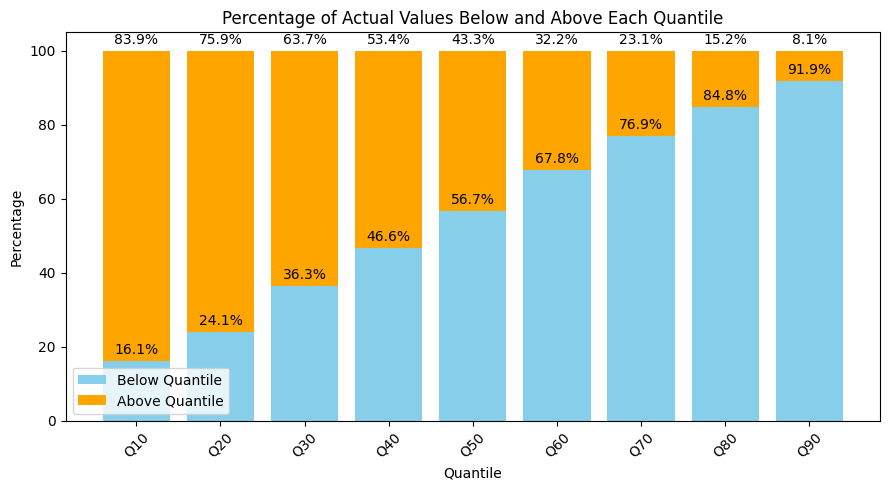

In [9]:
quantile_stats(quantile_predictions_df)

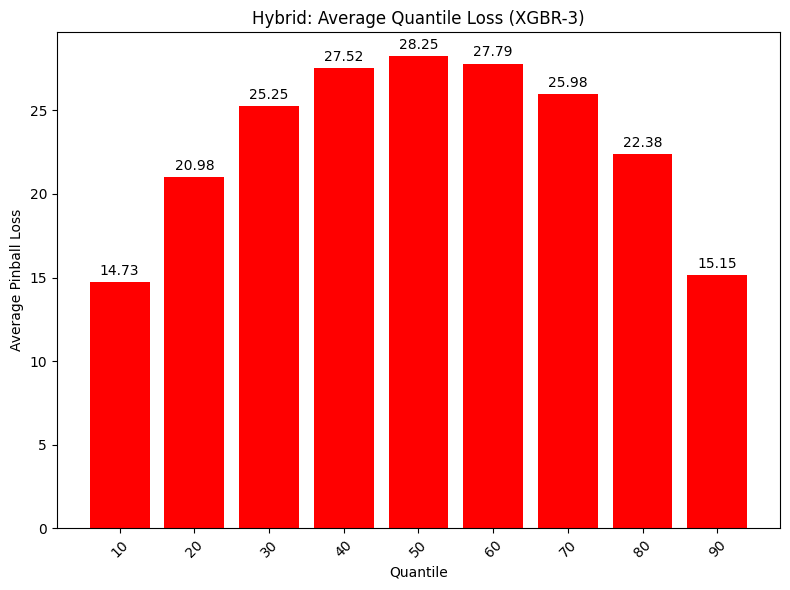

In [10]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'total_generation_MWh', "Hybrid: Average Quantile Loss (XGBR-3)")

/tmp/ipykernel_815276/2161571536.py:33: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



23.5200636789422


ValueError: bimodal is not a valid distribution name

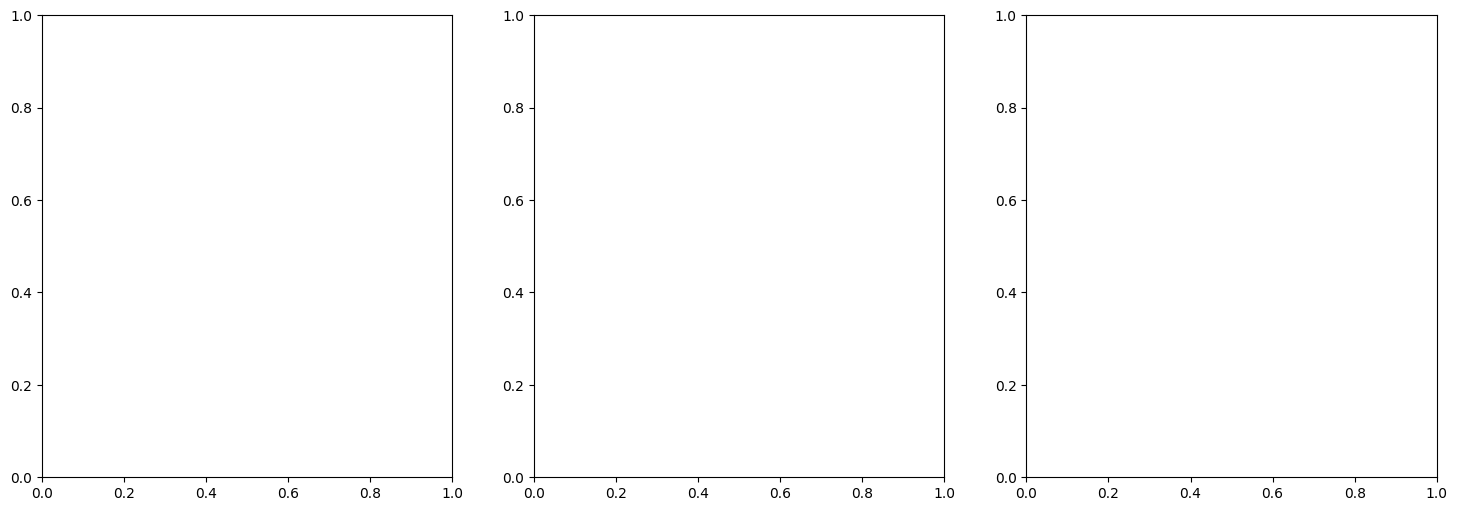

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb
from statsmodels.distributions.empirical_distribution import ECDF

# Initialize dictionary to store predictions
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = test_target_variable

# Define the quantiles
quantiles = range(10, 100, 10)

# Create a DMatrix from your dataframe if test_set is a DataFrame
dtest = xgb.DMatrix(Test_set)

# Define the quantiles
quantiles = range(10, 100, 10)

# Load models and predict
for qu in quantiles:
    model_path = f'models/ExtremeGB/W&S_XGBR_ALL_q{qu}.json'
    model = xgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(dtest)

# Create DataFrame from predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Process the predictions to ensure non-negative values
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].applymap(lambda x: max(x, 0))

# Assuming the function pinball_score exists and is correctly implemented
print(pinball_score(quantile_predictions_df, target_col='total_generation_MWh'))

# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# QQ Plot
stats.probplot(quantile_predictions_df['total_generation_MWh'], dist="bimodal", sparams=(2,), plot=axes[0])
axes[0].set_title('QQ Plot')

# CDF Plot
ecdf_actual = ECDF(quantile_predictions_df['total_generation_MWh'])
axes[1].plot(ecdf_actual.x, ecdf_actual.y, label='Actual Data CDF')
for qu in quantiles:
    ecdf_forecast = ECDF(quantile_predictions_df[f'q{qu}'])
    axes[1].plot(ecdf_forecast.x, ecdf_forecast.y, label=f'q{qu}')
axes[1].set_title('CDF Plot')
axes[1].legend()

# Density Plot
sns.kdeplot(quantile_predictions_df['total_generation_MWh'], label='Actual Data', fill=True, ax=axes[2])
for qu in quantiles:
    sns.kdeplot(quantile_predictions_df[f'q{qu}'], label=f'q{qu}', fill=True, ax=axes[2])
axes[2].set_title('Density Plot')
axes[2].legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_815276/156370917.py:22: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



23.5200636789422


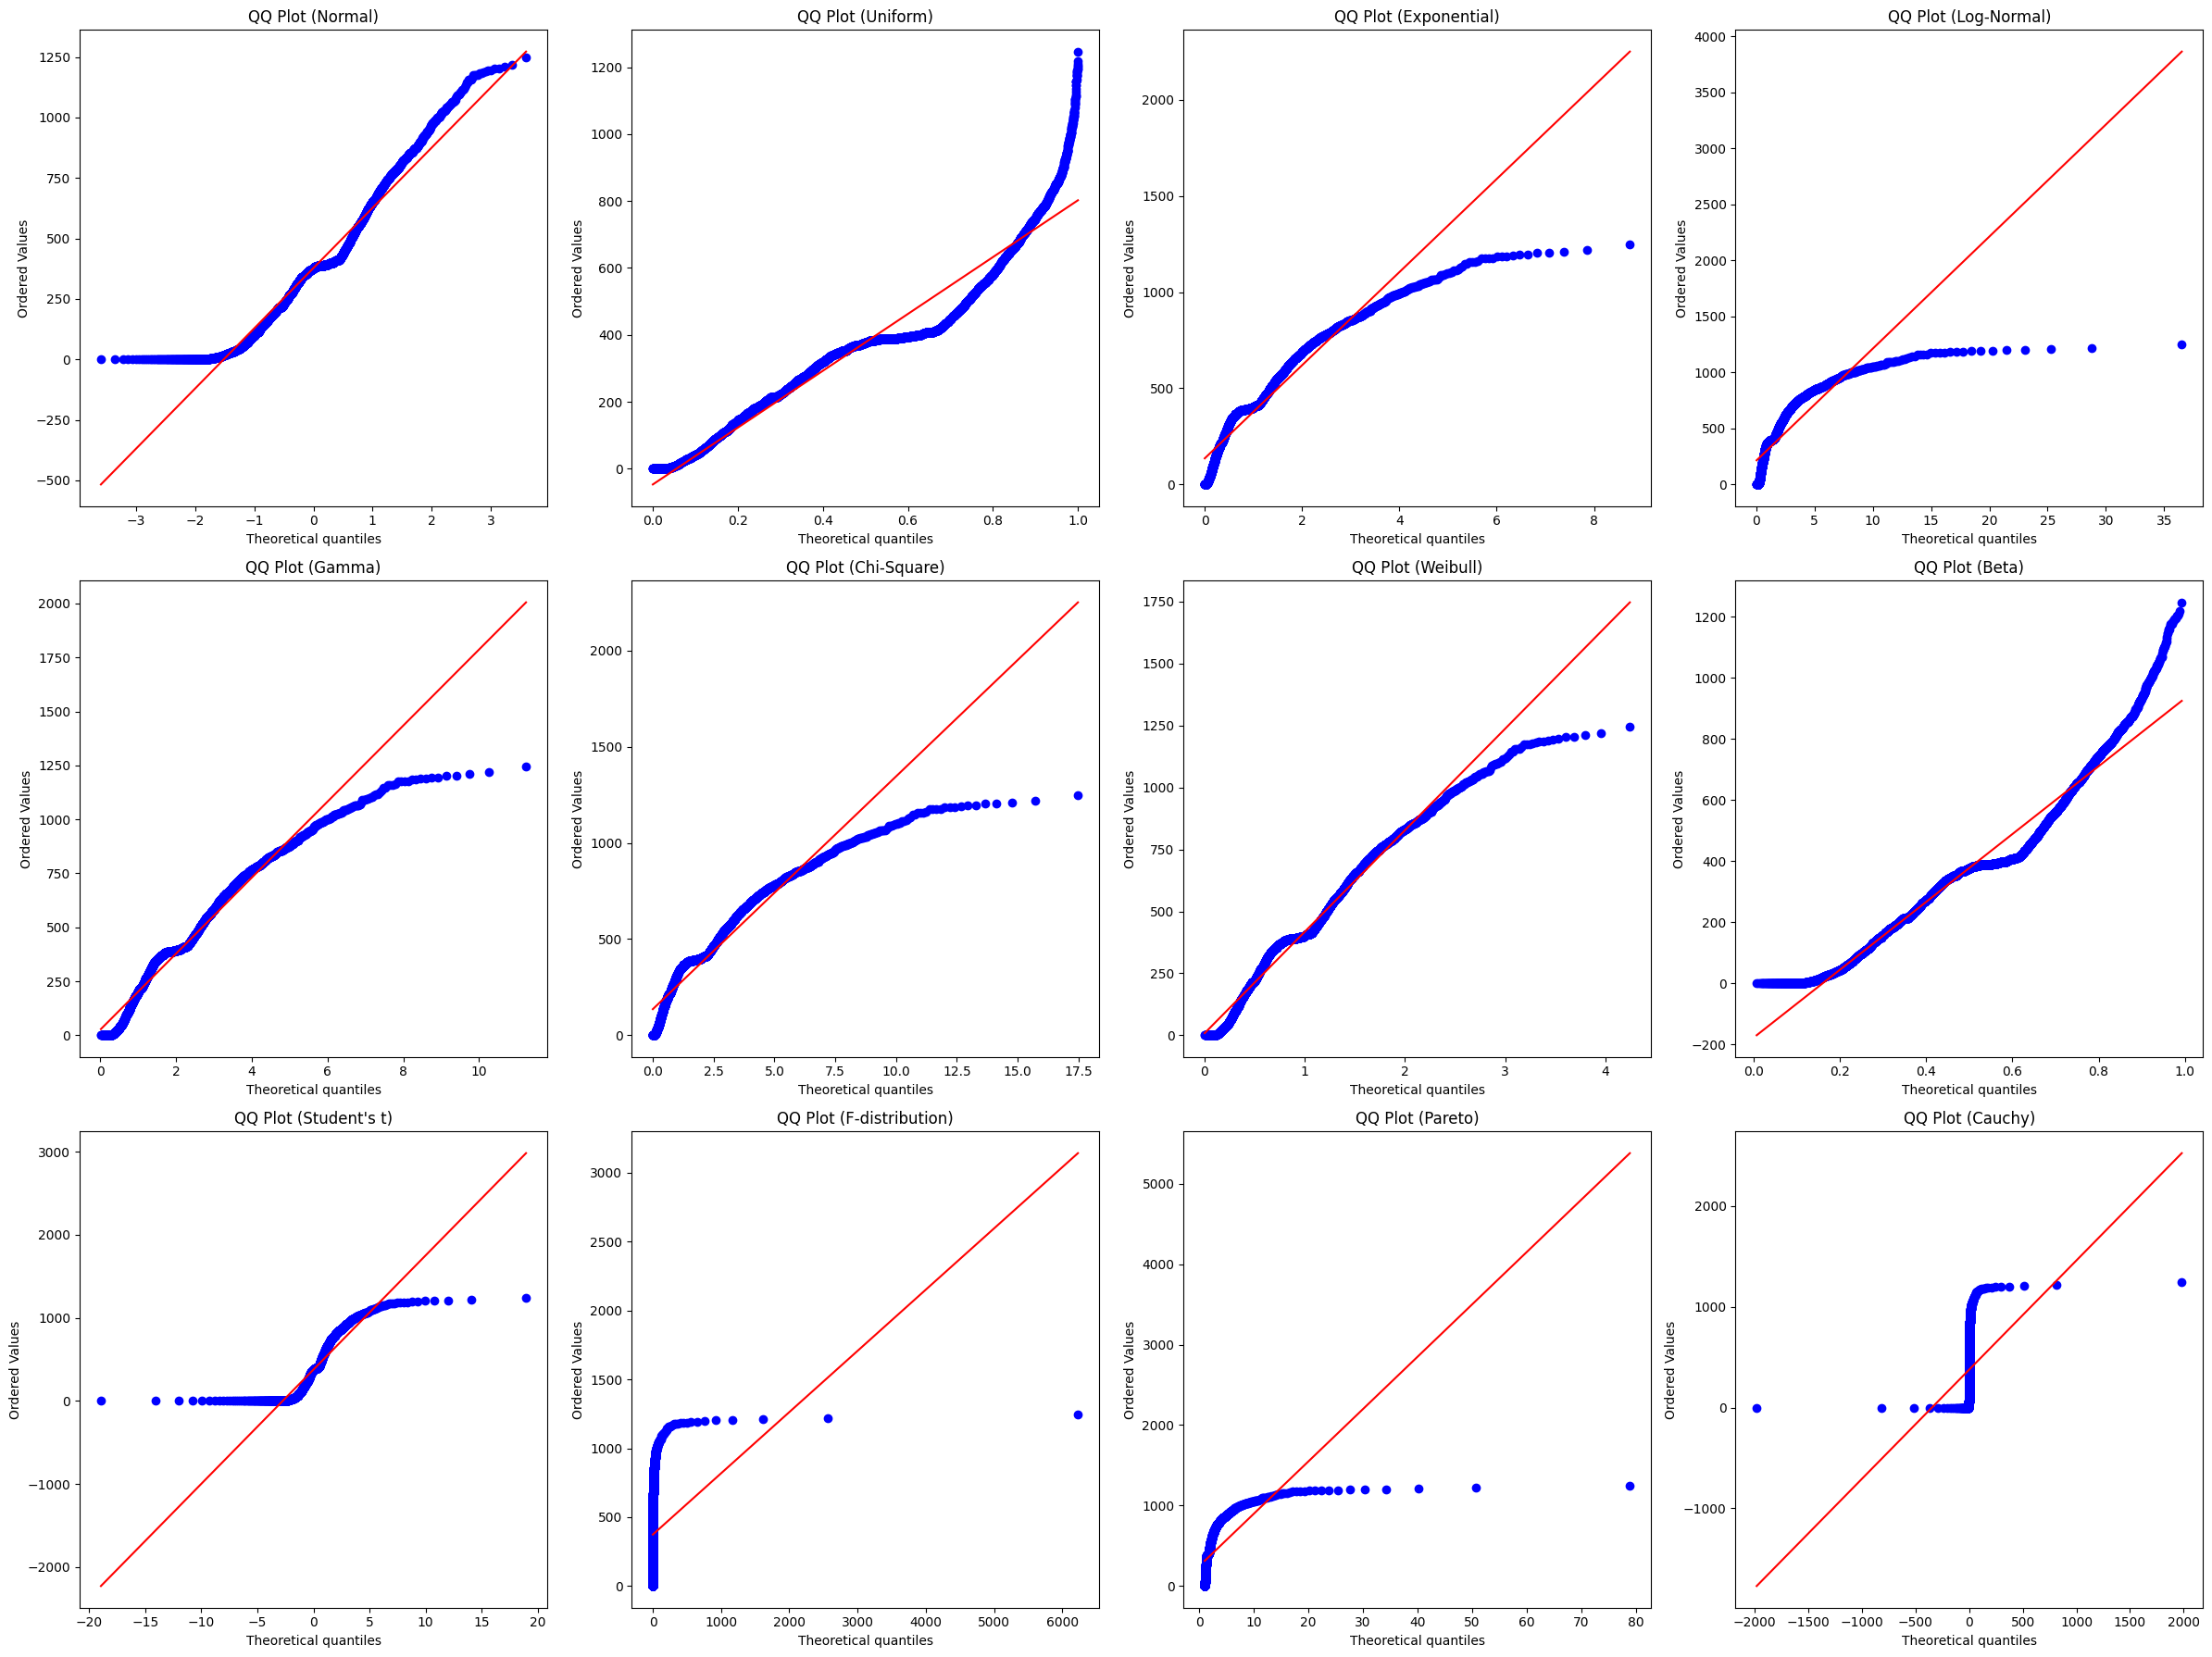

In [19]:
# Initialize dictionary to store predictions
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = test_target_variable

# Define the quantiles
quantiles = range(10, 100, 10)

# Create a DMatrix from your dataframe if test_set is a DataFrame
dtest = xgb.DMatrix(Test_set)

# Load models and predict
for qu in quantiles:
    model_path = f'models/ExtremeGB/W&S_XGBR_ALL_q{qu}.json'
    model = xgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(dtest)

# Create DataFrame from predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Process the predictions to ensure non-negative values
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].applymap(lambda x: max(x, 0))

# Assuming the function pinball_score exists and is correctly implemented
print(pinball_score(quantile_predictions_df, target_col='total_generation_MWh'))

# Create the plots
fig, axes = plt.subplots(3, 4, figsize=(24, 18))

# QQ Plots for different distributions
distributions = [
    ("norm", "Normal"),
    ("uniform", "Uniform"),
    ("expon", "Exponential"),
    ("lognorm", "Log-Normal", (1,)),
    ("gamma", "Gamma", (2,)),
    ("chi2", "Chi-Square", (2,)),
    ("weibull_min", "Weibull", (1.5,)),
    ("beta", "Beta", (2, 2)),
    ("t", "Student's t", (3,)),
    ("f", "F-distribution", (2, 2)),
    ("pareto", "Pareto", (2,)),
    ("cauchy", "Cauchy")
]

for i, dist in enumerate(distributions):
    row, col = divmod(i, 4)
    if len(dist) == 3:
        stats.probplot(quantile_predictions_df['total_generation_MWh'], dist=dist[0], sparams=dist[2], plot=axes[row, col])
    else:
        stats.probplot(quantile_predictions_df['total_generation_MWh'], dist=dist[0], plot=axes[row, col])
    axes[row, col].set_title(f'QQ Plot ({dist[1]})')

plt.tight_layout()
plt.show()

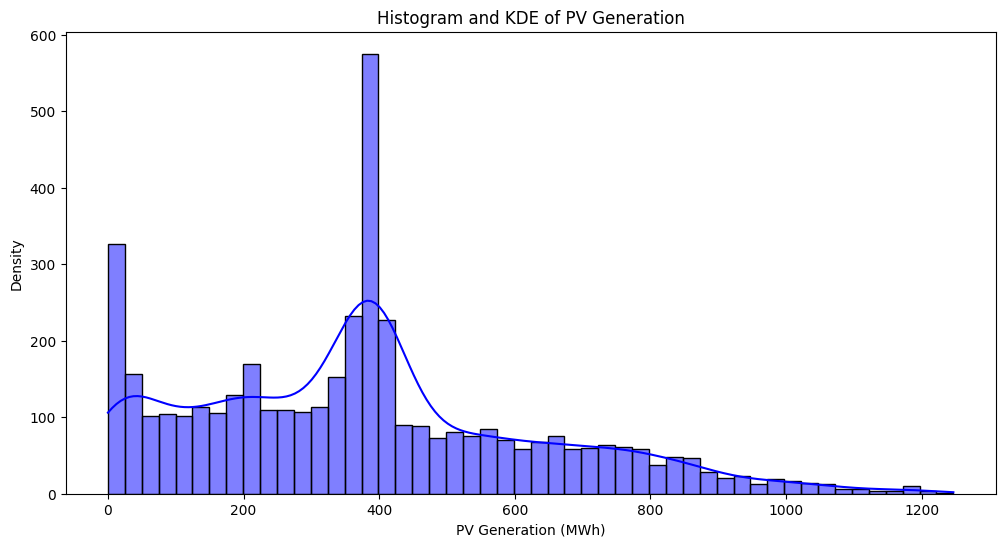

In [20]:
# Histogram and KDE Plot
plt.figure(figsize=(12, 6))
sns.histplot(test_target_variable, bins=50, kde=True, color='blue')
plt.title('Histogram and KDE of PV Generation')
plt.xlabel('PV Generation (MWh)')
plt.ylabel('Density')
plt.show()

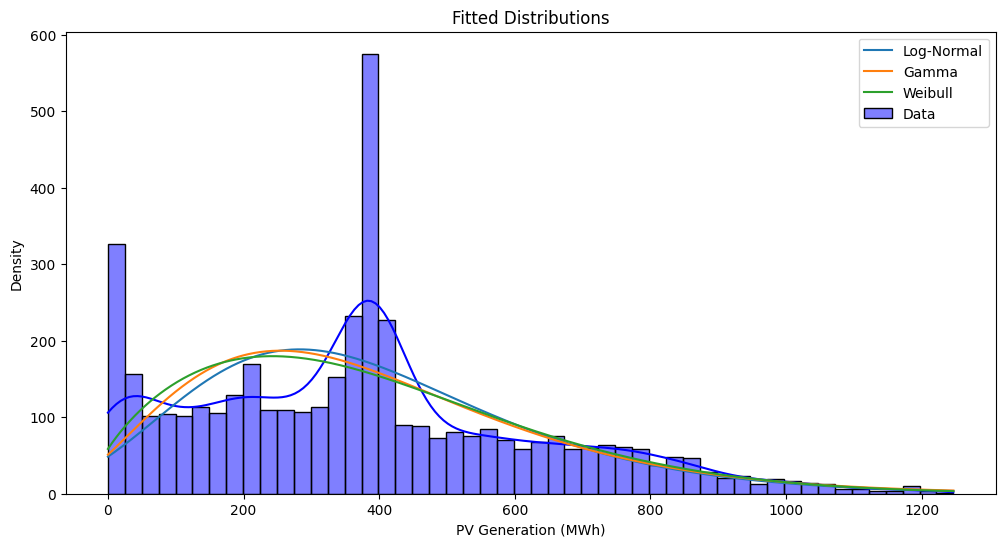

In [21]:
# Fit and compare distributions
distributions = {
    "Log-Normal": stats.lognorm.fit(test_target_variable[test_target_variable > 0]),
    "Gamma": stats.gamma.fit(test_target_variable[test_target_variable > 0]),
    "Weibull": stats.weibull_min.fit(test_target_variable[test_target_variable > 0])
}

# Plot the fitted distributions
x = np.linspace(test_target_variable.min(), test_target_variable.max(), 1000)
plt.figure(figsize=(12, 6))
sns.histplot(test_target_variable, bins=50, kde=True, color='blue', label='Data')
for name, params in distributions.items():
    if name == "Log-Normal":
        pdf = stats.lognorm.pdf(x, *params)
    elif name == "Gamma":
        pdf = stats.gamma.pdf(x, *params)
    elif name == "Weibull":
        pdf = stats.weibull_min.pdf(x, *params)
    plt.plot(x, pdf * len(test_target_variable) * (test_target_variable.max() - test_target_variable.min()) / 50, label=name)
plt.title('Fitted Distributions')
plt.xlabel('PV Generation (MWh)')
plt.ylabel('Density')
plt.legend()
plt.show()